# Efficient frontier calculation
This Jupyter notebook examines the Six Furniture Problem from Simon Benninga's Financial Modeling. The objective is to determine the optimal portfolio composition using given mean returns, volatilities (standard deviations of returns), and a specified variance-covariance matrix. All calculations are performed solely through matrix operations—no optimization solvers are used—and negative positions are permitted.

### Python libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import datetime as dt
import yfinance as yf

### Yahoo! download

In [4]:
pick = 'FLX' # make your random pick, if you know some tickers
yf.Ticker(pick).info

{'address1': 'Building 6',
 'address2': 'Zhongguancun Dongsheng International Science Park No.1 Yongtaizhuang North Road Haidian District',
 'city': 'Beijing',
 'zip': '100192',
 'country': 'China',
 'phone': '86 10 6292 3966',
 'website': 'https://www.ishansong.com',
 'industry': 'Integrated Freight & Logistics',
 'industryKey': 'integrated-freight-logistics',
 'industryDisp': 'Integrated Freight & Logistics',
 'sector': 'Industrials',
 'sectorKey': 'industrials',
 'sectorDisp': 'Industrials',
 'longBusinessSummary': "BingEx Limited, through its subsidiaries, engages in the provision of on-demand dedicated courier services under the FlashEx brand name in the People's Republic of China. The company offers Flash-Riders as service who provides the courier services. It serves individual and business customers, including local retailers, restaurants, and logistics players through its mobile platform and website. The company was founded in 2013 and is headquartered in Beijing, the People's 

In [5]:
short_name = yf.Ticker(pick).info.get('shortName')
sector = yf.Ticker(pick).info.get('sector')
industry = yf.Ticker(pick).info.get('industry')
print(f'symbol: {pick}, company: {short_name}, industry: {industry}')

symbol: FLX, company: BINGEX LIMITED, industry: Integrated Freight & Logistics


In [6]:
url = 'https://datahub.io/core/s-and-p-500-companies/r/constituents.csv'
sp500_tickers = pd.read_csv(url)

# Get the list of tickers, randomly by using sample
num_of_symbols = 100
seed = 426
tickers = sp500_tickers['Symbol'].sample(num_of_symbols, random_state=seed).tolist() # randome_state is the seed for the random choice

In [7]:
def get_company_info(tickers_list):
    """
    Fetch company names and sectors for a given list of tickers from Yahoo Finance.

    Parameters:
    tickers_list (list): List of ticker symbols to fetch data for.

    Returns:
    pd.DataFrame: DataFrame with company names and sectors, with tickers as index.
    """
    company_names = []
    sectors = []
    industry = []
    revenues = []
    ebitda = []

    # Loop through each ticker to get the data
    for ticker in tickers_list:
        stock = yf.Ticker(ticker)
        info = stock.info
        company_names.append(info.get('shortName', 'N/A'))  # Get company name, 'N/A' if not available
        sectors.append(info.get('sector', 'N/A'))  # Get sector, 'N/A' if not available
        industry.append(info.get('industry', 'N/A'))
        revenues.append(f"{info.get('totalRevenue', 'N/A'):,.0f}" if info.get('totalRevenue', 'N/A') != 'N/A' else 'N/A')
        ebitda.append(f"{info.get('ebitda', 'N/A'):,.0f}" if info.get('ebitda', 'N/A') != 'N/A' else 'N/A')



    # Create a DataFrame with tickers as the index, and columns for company name and sector
    df = pd.DataFrame({
        'company_name': company_names,
        'sector': sectors,
        'revenues': revenues,
        'ebitda': ebitda

    }, index=tickers_list)

    return df

In [8]:
get_company_info(tickers)

,company_name,sector,revenues,ebitda
MCHP,Microchip Technology Incorporat,Technology,"6,587,100,160","2,720,900,096"
UBER,"Uber Technologies, Inc.",Technology,"41,955,000,320","3,444,999,936"
WFC,Wells Fargo & Company,Financial Services,"77,875,003,392",N/A
MHK,"Mohawk Industries, Inc.",Consumer Cyclical,"10,812,014,592","1,549,473,024"
PEP,"Pepsico, Inc.",Consumer Defensive,"91,919,998,976","16,913,000,448"
...,...,...,...,...
PNW,Pinnacle West Capital Corporati,Utilities,"4,890,038,784","1,918,966,016"
ISRG,"Intuitive Surgical, Inc.",Healthcare,"7,866,899,968","2,505,100,032"
DHI,"D.R. Horton, Inc.",Consumer Cyclical,"36,801,400,832","6,202,899,968"
PHM,"PulteGroup, Inc.",Consumer Cyclical,"17,318,807,552","3,788,722,944"


### download stock prices

In [149]:
#Yahoo! connector to download the prices
stocks = tickers
start_date = '2020-01-01'
end_date = '2022-12-31' # dt.datetime.today().strftime('%Y-%m-%d') # until today
data = yf.download(stocks, start=start_date, end=end_date)

[*********************100%***********************]  100 of 100 completed


In [150]:
data.head()

Price                      Adj Close                                    \
Ticker                          ABBV        AMD         AMP       APTV   
Date                                                                     
2020-01-02 00:00:00+00:00  72.264885  49.099998  155.020126  96.065666   
2020-01-03 00:00:00+00:00  71.578949  48.599998  153.087296  93.861275   
2020-01-06 00:00:00+00:00  72.143829  48.389999  153.591095  92.115715   
2020-01-07 00:00:00+00:00  71.732269  48.250000  151.740723  90.958664   
2020-01-08 00:00:00+00:00  72.240677  47.830002  153.105606  92.853836   

Price                                                                   \
Ticker                          AXON       BALL        BIIB         BK   
Date                                                                     
2020-01-02 00:00:00+00:00  76.559998  60.674461  294.239990  43.622112   
2020-01-03 00:00:00+00:00  73.930000  61.519791  290.850006  43.065266   
2020-01-06 00:00:00+00:00  68.750000  60.949905  290.820007  43.467915   
2020-01-07 00:00:00+00:00  69.769997  60.712452  290.089996  43.904812   
2020-01-08 00:00:00+00:00  69.610001  61.234859  292.660004  43.956219   

Price                                              ...   Volume           \
Ticker                            BKNG        BKR  ...      TMO      TXN   
Date                                               ...                     
2020-01-02 00:00:00+00:00  2059.755859  22.192818  ...  1173300  4614000   
2020-01-03 00:00:00+00:00  2050.720703  22.218815  ...   819600  4057200   
2020-01-06 00:00:00+00:00  2032.770020  22.114822  ...  1010000  4345400   
2020-01-07 00:00:00+00:00  2053.272217  21.742199  ...   917700  7184100   
2020-01-08 00:00:00+00:00  2048.158936  21.464893  ...   939100  3546900   

Price                                                                    \
Ticker                         UBER      UNH      UNP     VRSK      WBD   
Date                                                                      
2020-01-02 00:00:00+00:00  20578900  2543400  2444800   845100  3249300   
2020-01-03 00:00:00+00:00  18822700  2711400  2344200   876900  3599600   
2020-01-06 00:00:00+00:00  21204700  3079100  3142500   656200  2416900   
2020-01-07 00:00:00+00:00  30119600  2492900  4096400  1514700  3102000   
2020-01-08 00:00:00+00:00  43944400  3379200  2817500   773100  3674100   

Price                                                 
Ticker                          WFC     WST     WYNN  
Date                                                  
2020-01-02 00:00:00+00:00  16803100  527800  3006500  
2020-01-03 00:00:00+00:00  15608800  316100  1760500  
2020-01-06 00:00:00+00:00  13200300  331900  1357900  
2020-01-07 00:00:00+00:00  13278600  289800  1722100  
2020-01-08 00:00:00+00:00  16585600  533900  1176200  

[5 rows x 600 columns]

In [151]:
data = data.reindex(columns=pd.MultiIndex.from_product([data.columns.levels[0], tickers])) # reorder the columns
data.head()

Price                      Adj Close                                    \
                                MCHP       UBER        WFC         MHK   
Date                                                                     
2020-01-02 00:00:00+00:00  49.835030  30.990000  47.324253  134.789993   
2020-01-03 00:00:00+00:00  48.741993  31.370001  47.033695  130.949997   
2020-01-06 00:00:00+00:00  48.042641  31.580000  46.751957  131.000000   
2020-01-07 00:00:00+00:00  51.266163  32.810001  46.364559  128.009995   
2020-01-08 00:00:00+00:00  50.617760  33.930000  46.505417  127.610001   

Price                                                                   \
                                  PEP        HAS         CF        LYV   
Date                                                                     
2020-01-02 00:00:00+00:00  118.635849  87.750076  41.256386  71.889999   
2020-01-03 00:00:00+00:00  118.469864  87.516808  40.971867  71.639999   
2020-01-06 00:00:00+00:00  118.924088  87.775063  40.900723  71.739998   
2020-01-07 00:00:00+00:00  117.054863  86.133865  40.527287  70.910004   
2020-01-08 00:00:00+00:00  117.657539  87.433495  40.714012  71.690002   

Price                                              ...  Volume           \
                                  HII         TXN  ...    EQIX      FTV   
Date                                               ...                    
2020-01-02 00:00:00+00:00  230.124771  112.741287  ...  448500  1939007   
2020-01-03 00:00:00+00:00  237.005569  111.244675  ...  385200  1366483   
2020-01-06 00:00:00+00:00  238.354767  110.470268  ...  284200  2373390   
2020-01-07 00:00:00+00:00  240.567383  112.602051  ...  252600  2004254   
2020-01-08 00:00:00+00:00  241.916611  112.906586  ...  261000  2733204   

Price                                                                   \
                               BKR     FAST      MCD      PNW     ISRG   
Date                                                                     
2020-01-02 00:00:00+00:00  4714900  4190300  3554200   744100  1623000   
2020-01-03 00:00:00+00:00  3125700  4101300  2767600  1058500  1256100   
2020-01-06 00:00:00+00:00  4248600  4135200  4660400   908800  1574400   
2020-01-07 00:00:00+00:00  5493400  3108300  4047400   931300  3515100   
2020-01-08 00:00:00+00:00  5871700  3795900  5284200   797200  2679300   

Price                                                  
                               DHI      PHM         C  
Date                                                   
2020-01-02 00:00:00+00:00  3492000  2049300  12728900  
2020-01-03 00:00:00+00:00  4330400  2607200  12437400  
2020-01-06 00:00:00+00:00  4305500  2145700  10059500  
2020-01-07 00:00:00+00:00  4440400  4916900  10469100  
2020-01-08 00:00:00+00:00  5279600  5464200  11292400  

[5 rows x 600 columns]

In [152]:
def stock_KPIs(dataframe, start_date, end_date):
  '''
    Explanation
    Daily Returns Calculation: The calculate_individual_returns function calculates returns per stock, leaving NaN where data is missing, so no artificial data is introduced.
    Mean Returns Calculation: Using mean(skipna=True) calculates the mean for each stock based only on existing data, ignoring NaN values.
    Covariance Matrix Calculation: The covariance matrix is calculated using pairwise deletion (min_periods=1), so each covariance value is based only on dates where both stocks have available data.
    '''
  filtered_df = dataframe.loc[start_date:end_date] # option to slice the data frame by date
  filtered_df = filtered_df.where(filtered_df > 0) # Replace zero or negative values with NaN (to handle cases where data might be invalid)
  filtered_df = filtered_df.ffill()  # Forward-fill only for zero or negative values that are transformed to NaN, Note: This still keeps original missing values as NaN

  def calculate_individual_returns(df):
        # Calculate daily log returns without filling NaNs (preserves missing data)
        return df.apply(lambda x: np.log(x / x.shift(1)))

  p_daily_returns = calculate_individual_returns(filtered_df) # still keeps the non-trading periods

  mean_returns = p_daily_returns.mean(skipna=True) * 252  # Annualized mean returns ignoring NaNs
  variance = p_daily_returns.var(skipna=True) * 252 # Annualized variance ignoring NaNs
  volatility = p_daily_returns.std(skipna=True) * np.sqrt(252)  # Annualized standard deviation
  cov_matrix_pairwise = p_daily_returns.cov(min_periods=1) * 252  # Annualized pairwise covariance matrix

  return {
      'data frame' : filtered_df,
      'variance': variance,
      'volatility': volatility,
      'mean_returns': mean_returns, # series for mean returns
      'cov_matrix': cov_matrix_pairwise
  }

In [153]:
stock_close = data['Adj Close']

In [154]:
# to check - analysis shall use annualized figures
mean_returns = stock_KPIs(stock_close, start_date, end_date)['mean_returns'].rename('mean_returns')
volatility = stock_KPIs(stock_close, start_date, end_date)['volatility'].rename('volatility')
variance = stock_KPIs(stock_close, start_date, end_date)['variance'].rename('variance')
cov_matrix = stock_KPIs(stock_close, start_date, end_date)['cov_matrix']

In [155]:
metrics = pd.DataFrame({
    'mean_returns': mean_returns,
    'variance': np.diag(cov_matrix),
    'volatility': volatility
}, index=mean_returns.index)
metrics

,mean_returns,variance,volatility
MCHP,0.102879,0.245228,0.495205
UBER,-0.075315,0.383681,0.619420
WFC,-0.062603,0.202728,0.450253
MHK,-0.092319,0.299046,0.546851
PEP,0.123234,0.064828,0.254613
...,...,...,...
PNW,-0.008323,0.103638,0.321928
ISRG,0.095897,0.160020,0.400025
DHI,0.187103,0.219495,0.468503
PHM,0.067001,0.249074,0.499073


In [156]:
cov_matrix

,MCHP,UBER,WFC,MHK,PEP,HAS,CF,LYV,HII,TXN,...,EQIX,FTV,BKR,FAST,MCD,PNW,ISRG,DHI,PHM,C
MCHP,0.245228,0.159649,0.122762,0.142085,0.063170,0.106097,0.104598,0.149561,0.061275,0.147661,...,0.078216,0.104917,0.120410,0.087499,0.073697,0.068106,0.120803,0.134630,0.138411,0.134322
UBER,0.159649,0.383681,0.104677,0.152401,0.033167,0.088717,0.105234,0.193026,0.037935,0.093349,...,0.056287,0.094604,0.115182,0.054638,0.068671,0.061819,0.121286,0.125482,0.137988,0.132424
WFC,0.122762,0.104677,0.202728,0.138470,0.056991,0.090753,0.110244,0.132236,0.080771,0.081231,...,0.044546,0.093655,0.142665,0.067080,0.068162,0.073574,0.081405,0.090836,0.104696,0.173204
MHK,0.142085,0.152401,0.138470,0.299046,0.053339,0.113079,0.113897,0.161636,0.074313,0.087343,...,0.052739,0.114314,0.135217,0.074873,0.071803,0.077544,0.095840,0.145126,0.176140,0.150719
PEP,0.063170,0.033167,0.056991,0.053339,0.064828,0.047275,0.039139,0.039267,0.039423,0.050537,...,0.051651,0.044429,0.049836,0.051630,0.042707,0.051152,0.055037,0.053848,0.056256,0.056356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PNW,0.068106,0.061819,0.073574,0.077544,0.051152,0.055341,0.060799,0.063079,0.053168,0.047490,...,0.052444,0.058753,0.073894,0.046203,0.055015,0.103638,0.060163,0.070652,0.081742,0.079495
ISRG,0.120803,0.121286,0.081405,0.095840,0.055037,0.073707,0.070022,0.101950,0.050916,0.086266,...,0.081545,0.080768,0.086459,0.067757,0.061345,0.060163,0.160020,0.098264,0.105657,0.093993
DHI,0.134630,0.125482,0.090836,0.145126,0.053848,0.088256,0.079208,0.115748,0.065900,0.087287,...,0.075164,0.091064,0.090621,0.072988,0.073264,0.070652,0.098264,0.219495,0.212191,0.107858
PHM,0.138411,0.137988,0.104696,0.176140,0.056256,0.099208,0.093494,0.134772,0.071111,0.088190,...,0.076922,0.107050,0.108576,0.079758,0.082705,0.081742,0.105657,0.212191,0.249074,0.125306


### stocks - returns and volatility

- The example assumes that we already have a variance-covariance matrix, a vector of expected returns (mean returns, or mean).
- Calculation of such metrics is discussed in another workbook.

In [157]:
#define risk_free_rate and
risk_free_rate = 0.05
constant = 0.195

#define the range of calculation (proportion of x portfolio)
propx_range = np.linspace(-0.5, 2, 100)

### functions

In [158]:
def portfolio_weights(cov_matrix, returns, col_name):
    '''
    This function calculates the portfolio weights from variance-covariance matrix and the mean returns.
    The method is also called: mean-variance optimization, where we product the inverse of the var-covariance matrix and the returns vector.
    The distribution of the product gives the optimized portfolio weights.
    '''
    # Calculate the values (weights before normalization)
    values = np.linalg.inv(cov_matrix).dot(returns)

    # Normalize the weights and convert them into a DataFrame
    weights = pd.Series(values / np.sum(values), index=cov_matrix.index, name=col_name)

    return weights


In [159]:
def portfolio_stats(weights_series, returns_series, cov_matrix):
    '''
    This function is collection of mean, variance and volatility (sigma) calculation of a given portfolio.
    The calculation is based on matrices (weights as series, returns as series, and cov_matrix as data frame)
    The resulting informatin is stored in a dictionary.
    '''

    rounding = 5
    portfolio_mean = np.dot(weights_series, returns_series)
    portfolio_var = np.dot(weights_series.T, np.dot(cov_matrix, weights_series))
    portfolio_sigma = np.sqrt(portfolio_var)
    return {
        'mean': portfolio_mean.round(rounding),
        'var': portfolio_var.round(rounding),
        'sigma': portfolio_sigma.round(rounding)
    }

In [160]:
def portfolio_mix(propx_range, var_x, var_t, cov_xt, mean_x, mean_t):
    '''
    This function calculates the of the various mix of two portfolios (x portfolio, and t portfolio).
    The mix is determined by a propx variable, where propx represents x portfolio weight, (1-propx) represents the t portfolio weight in the calculation.
    The function iterates through the propx_range and calculates the mean and sigma values for each of the propx_range elements.
    The resulting values are stored in a data frame (portfolio_mix_df)
    '''

    results = []

    for propx in propx_range:
        # Calculate sigma (portfolio risk)
        sigma = (propx**2 * var_x + (1 - propx)**2 * var_t + 2 * propx * (1 - propx) * cov_xt)**0.5

        # Calculate mean (portfolio expected return)
        mean = propx * mean_x + (1 - propx) * mean_t

        # Store the results as a tuple (propx, sigma, mean)
        results.append((propx, sigma, mean))

    # Convert results to a DataFrame for easy handling
    portfolio_mix_df = pd.DataFrame(results, columns=['propx', 'sigma', 'mean'])

    return portfolio_mix_df


In [161]:
def rf_portfolio_mix(propx_range, sigma_y, mean_y, risk_free_rate):

    '''
    This function calculates the mean, sigma, of two portfolios, where the first portfolio
    is a risk free instrument (government bond, with a yield of risk_free_rate.
    the resulting data frame consist of different portfolio mixes, with each scenario with different weights.

    '''
    results = []

    for propx in propx_range:
        # Calculate sigma (portfolio risk)
        sigma = (1 - propx) * sigma_y

        # Calculate the portfolio return
        portfolio_return = propx * risk_free_rate + (1 - propx) * mean_y

        # Store the results as a tuple (propx, sigma, return)
        results.append((propx, sigma, portfolio_return))

    # Convert results to a DataFrame for easy handling
    rf_portfolio_mix_df = pd.DataFrame(results, columns=['propx', 'sigma', 'return'])

    return rf_portfolio_mix_df


In [162]:
def portfolio_covar(weights_a, weights_b, sigma_a, sigma_b, cov_matrix):
    '''
    This function calculates the covariance and correlation of two portfilios (a portfolio, b portfolio)
    Based on weights, sigme, variance-covariance matrix, the function calculates the coveriance, and correlation data in a dictionary.
    '''
    rounding = 5
    covar = np.dot(weights_a.T, np.dot(cov_matrix, weights_b))

    # Calculate the correlation
    correlation = covar / (sigma_a * sigma_b)

    return {
        'covar': covar.round(rounding),
        'correlation': correlation.round(rounding)
    }

In [163]:
def chart(x_min=0,
          x_max=2,
          y_min=-0.2,
          y_max=2,
                title='Efficient frontier',
                xlabel='Risk (Sigma)',
                ylabel='Return'):
    """
    Sets up the chart with specified axis limits, labels, and title.
    Returns the figure and axes objects for further plotting.
    """
    fig, ax = plt.subplots(figsize=(15, 6))

    # Set x and y axis limits
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Adding labels and title
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Hide top and right spines
    ax.spines[['top', 'right']].set_visible(False)

    # Turn off grid
    ax.grid(False)

    return fig, ax

### portfolios
- portfolio x: based on individual stock returns
- portfolio y: based on individual stock returns reduced by the risk free rate
- portfolio t: based on individual stock returns reduced by constant

constant represent the kind of expectation of the investor (however, from math point of view this is just a third point on the plane to have the calculation done. It can be any number around the portfolio return ranges)


In [164]:
# defining portolio weights
x_weights = portfolio_weights(cov_matrix, metrics['mean_returns'], 'x_weights')
y_weights = portfolio_weights(cov_matrix, metrics['mean_returns']-risk_free_rate, 'y_weights')
t_weights = portfolio_weights(cov_matrix, metrics['mean_returns']-constant, 't_weights')

In [165]:
x_stats = portfolio_stats(x_weights, metrics['mean_returns'], cov_matrix)
y_stats = portfolio_stats(y_weights, metrics['mean_returns'], cov_matrix)
t_stats = portfolio_stats(t_weights, metrics['mean_returns'], cov_matrix)

In [166]:
xy_covar = portfolio_covar(x_weights, y_weights, x_stats['sigma'], y_stats['sigma'], cov_matrix )
xt_covar = portfolio_covar(x_weights, t_weights, x_stats['sigma'], t_stats['sigma'], cov_matrix )

In [167]:
portfolio_mix_df = portfolio_mix(propx_range, x_stats['var'], t_stats['var'], xt_covar['covar'], x_stats['mean'], t_stats['mean'])

In [168]:
rf_portfolio_mix_df = rf_portfolio_mix(propx_range, y_stats['sigma'], y_stats['mean'], risk_free_rate)

In [169]:
y_stats

{'mean': 20.40024, 'var': 26.05764, 'sigma': 5.10467}

### risk and return scatter plot
The following chart illustrates the relationship between risk, represented by sigma (or volatility), and returns (mean). In financial theory, stocks are often evaluated by comparing their potential returns to the risks associated with them. A higher risk is generally associated with the potential for higher returns, and this chart visually demonstrates this connection.

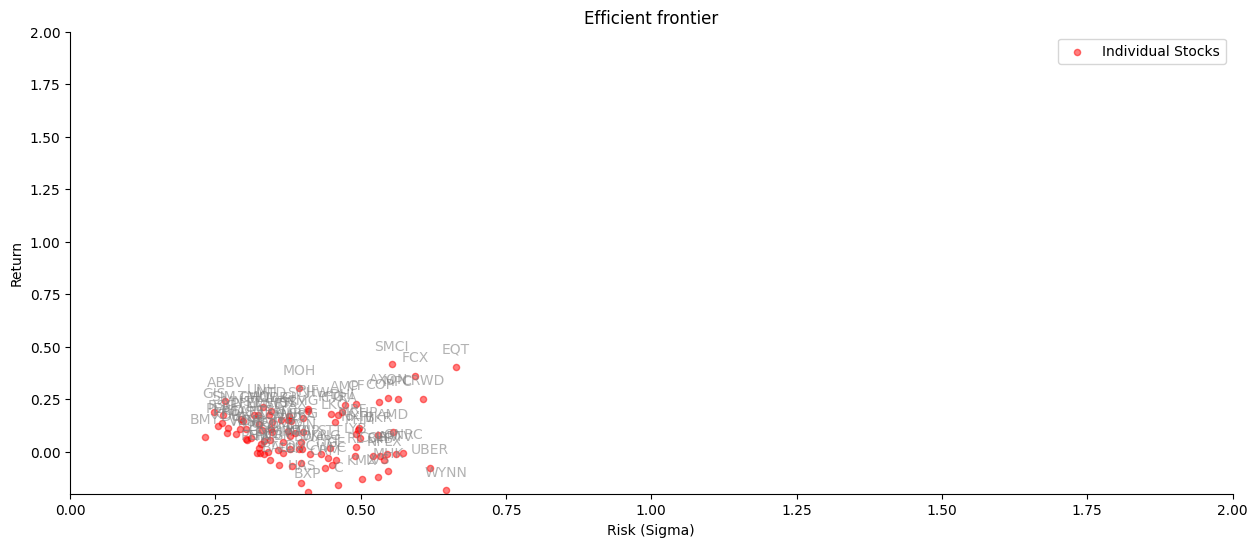

In [170]:
fig, ax = chart() # pre-defined chart

# Individual stocks
ax.scatter(metrics['volatility'], metrics['mean_returns'], color='red', alpha = 0.5, s=20, label='Individual Stocks')

for i, ticker in enumerate(metrics.index):
    ax.annotate(
        ticker,
        (metrics['volatility'].iloc[i], metrics['mean_returns'].iloc[i]),
        textcoords="offset points",
        xytext=(0, 10),
        alpha=0.6,
        color='grey',
        ha='center'
    )

# Update the legend
ax.legend()

# Redraw the figure to update the display
plt.show()

### envelop portfolios - calculation of efficient frontier
This section explores how to achieve optimal diversification using the Envelop Portfolio Theory, developed by Harry Markowitz. This approach combines assets in a way that we can maximize returns for a given level of risk or minimize risk for a given level of return. The Efficient Frontier is a set of portfolios that are optimal in the sense that no other portfolio offers higher returns for the same level of risk.

We calculate three key types of envelop portfolios:

- x: A portfolio optimized by returns.
- y: A portfolio where weights are adjusted by returns reduced by the risk-free rate.
- t: A portfolio where returns are reduced by a constant.

The chart demonstrates that portfolios on the Efficient Frontier a better risk-return tradeoff than portfolios below it.

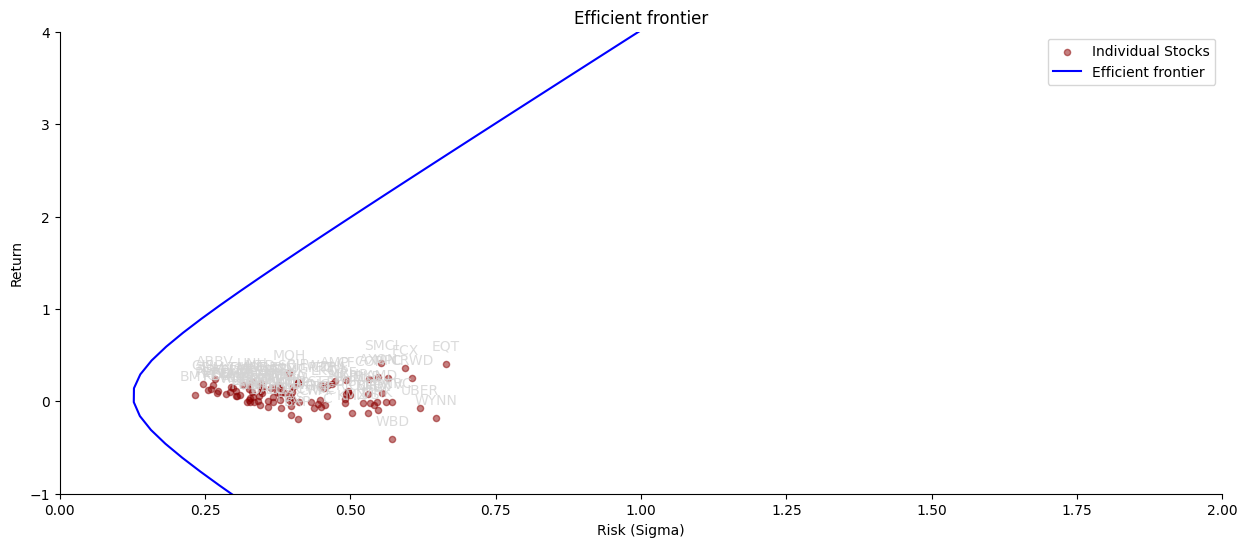

In [171]:
fig, ax = chart(y_max = 4, y_min=-1) # pre-defined chart

# Individual stocks
ax.scatter(metrics['volatility'], metrics['mean_returns'], color='darkred', alpha = 0.5, s=20, label='Individual Stocks')

for i, ticker in enumerate(metrics.index):
    ax.annotate(
        ticker,
        (metrics['volatility'].iloc[i], metrics['mean_returns'].iloc[i]),
        textcoords="offset points",
        xytext=(0, 10),
        alpha=0.8,
        color='lightgrey',
        ha='center'
    )

plt.plot(portfolio_mix_df['sigma'], portfolio_mix_df['mean'], label="Efficient frontier", color='blue')

# Update the legend
ax.legend()

# Redraw the figure to update the display
plt.show()

### The Risk-Free Rate – A Key Reference Point in Capital Markets
In the world of investing, the risk-free rate serves as the baseline against which all other investments are measured. Theoretically, only one instrument is considered risk-free: the government bond. Government bonds, issued by stable governments, are assumed to have virtually no risk of default.

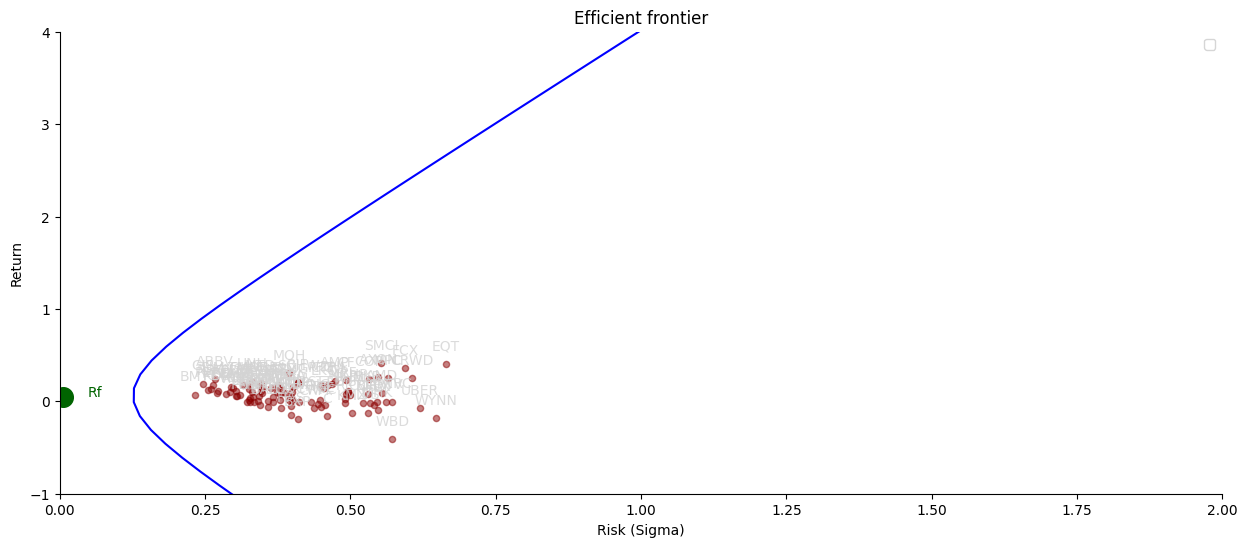

In [173]:
fig, ax = chart(y_max = 4, y_min=-1) # pre-defined chart

# Individual stocks
ax.scatter(metrics['volatility'], metrics['mean_returns'], color='darkred', alpha = 0.5, s=20, label='Individual Stocks')

for i, ticker in enumerate(metrics.index):
    ax.annotate(
        ticker,
        (metrics['volatility'].iloc[i], metrics['mean_returns'].iloc[i]),
        textcoords="offset points",
        xytext=(0, 10),
        alpha=0.8,
        color='lightgrey',
        ha='center'
    )

plt.plot(portfolio_mix_df['sigma'], portfolio_mix_df['mean'], label="Efficient frontier", color='blue')

# Risk-free rate
ax.scatter(
    0.005,
    risk_free_rate,
    color='darkgreen',
    marker='o',
    s=200,
    label='Risk-Free Rate'
)

ax.annotate(
    'Rf',
    (0, risk_free_rate),
    textcoords="offset points",
    xytext=(25, 0),
    ha='center',
    color='darkgreen'
)

# Update the legend
ax.legend('')

# Redraw the figure to update the display
plt.show()

### The Risk-Free Rate as an Efficiency Enhancer
An investor can significantly improve the efficiency of their portfolio by combining it with a risk-free asset, such as a government bond. This strategy can lead to lower risk and potentially higher returns. The reduction in risk is straightforward, as mixing shares with government bonds naturally dilutes the overall volatility of the portfolio.

Higher returns, however, can be achieved through leverage. By borrowing funds (using debt) to purchase more stocks, investors can amplify their returns. In doing so, they exchange a portion of safety for higher potential gains.

This effect is visually demonstrated by the second line on the chart, where we see the impact of blending the risk-free rate with the portfolio, creating a more efficient combination of risk and reward.

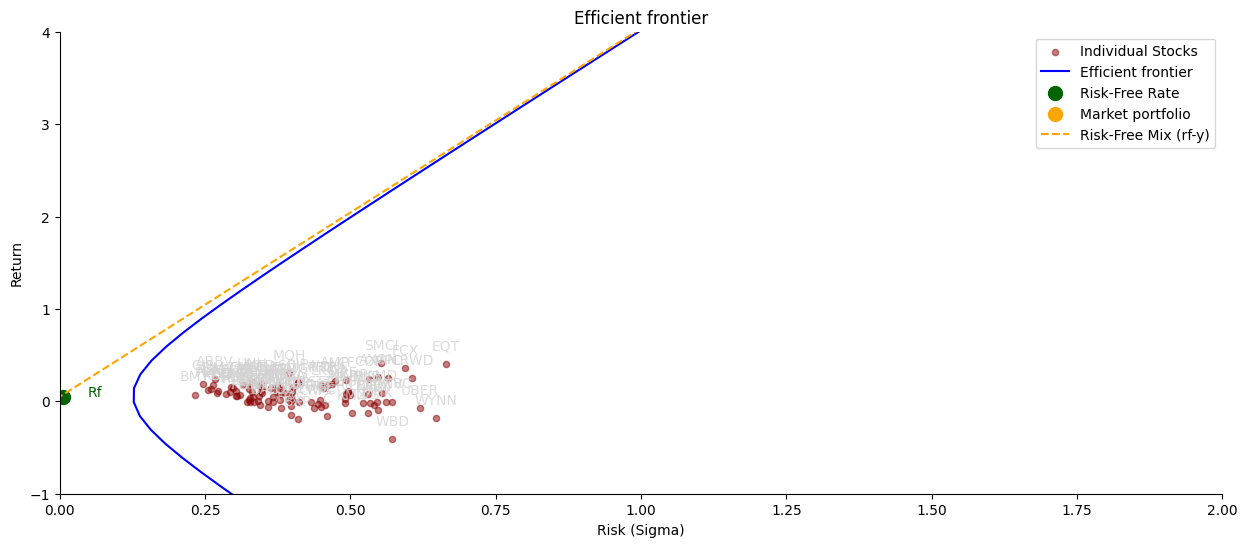

In [174]:
fig, ax = chart(y_max = 4, y_min=-1) # pre-defined chart

# Individual stocks
ax.scatter(metrics['volatility'], metrics['mean_returns'], color='darkred', alpha = 0.5, s=20, label='Individual Stocks')

for i, ticker in enumerate(metrics.index):
    ax.annotate(
        ticker,
        (metrics['volatility'].iloc[i], metrics['mean_returns'].iloc[i]),
        textcoords="offset points",
        xytext=(0, 10),
        alpha=0.8,
        color='lightgrey',
        ha='center'
    )

plt.plot(portfolio_mix_df['sigma'], portfolio_mix_df['mean'], label="Efficient frontier", color='blue')

ax.scatter(
    0.005,
    risk_free_rate,
    color='darkgreen',
    marker='o',
    s=100,
    label='Risk-Free Rate'
)


ax.scatter(
    y_stats['sigma'],
    y_stats['mean'],
    color='orange',
    marker='o',
    s=100,
    label='Market portfolio'
)

ax.annotate(
    'Rf',
    (0, risk_free_rate),
    textcoords="offset points",
    xytext=(25, 0),
    ha='center',
    color='darkgreen'
)

ax.annotate(
    'Market Portfolio',
    (y_stats['sigma'], y_stats['mean']),
    textcoords="offset points",
    xytext=(25, 10),
    ha='center',
    color='black'
)

plt.plot(rf_portfolio_mix_df['sigma'], rf_portfolio_mix_df['return'], label="Risk-Free Mix (rf-y)", color='orange', linestyle='--')
# Update the legend
ax.legend()

# Redraw the figure to update the display
plt.show()

In [175]:
def calculate_betas(max_sharpe_weights, metrics, cov_matrix):
    """
    Calculate beta values for all stocks in the metrics DataFrame relative to the maximum Sharpe portfolio.

    Parameters:
    - max_sharpe_weights: DataFrame with weights for the stocks in the maximum Sharpe portfolio.
    - metrics: DataFrame containing returns and volatility data for all stocks.
    - cov_matrix: Full covariance matrix of all stocks.

    Returns:
    - A DataFrame with the original metrics and an added column for beta values for each stock.
    """
    # Extract portfolio stocks and weights from max_sharpe_weights
    portfolio_stocks = max_sharpe_weights.index
    portfolio_weights = max_sharpe_weights['weights']

    # Calculate the market portfolio variance using the maximum Sharpe portfolio weights
    filtered_cov_matrix = cov_matrix.loc[portfolio_stocks, portfolio_stocks]
    market_var = portfolio_weights.T @ filtered_cov_matrix.to_numpy() @ portfolio_weights

    # Initialize a Series to store beta values for all stocks
    beta_values = pd.Series(index=metrics.index, dtype=float)

    # Calculate beta for each stock in the entire metrics DataFrame
    for ticker in metrics.index:
        # Covariance of the stock with the market portfolio
        stock_cov_with_market = cov_matrix.loc[ticker, portfolio_stocks].to_numpy() @ portfolio_weights
        beta_values[ticker] = stock_cov_with_market / market_var

    # Add the beta column to the metrics DataFrame
    metrics['Beta'] = beta_values
    return metrics


In [176]:
sharpe_weights = pd.DataFrame(y_weights.rename('weights'))
beta_df = calculate_betas(sharpe_weights, metrics, cov_matrix)
mp = {'mean_returns': y_stats['mean'], 'variance': y_stats['var'], 'volatility': y_stats['sigma'], 'Beta': 1}
beta_mp_df = beta_df.copy()
beta_mp_df.loc['market portfolio'] = mp
beta_mp_df

,mean_returns,variance,volatility,Beta
MCHP,0.102879,0.245228,0.495205,0.002598
UBER,-0.075315,0.383681,0.619420,-0.006158
WFC,-0.062603,0.202728,0.450253,-0.005533
MHK,-0.092319,0.299046,0.546851,-0.006993
PEP,0.123234,0.064828,0.254613,0.003599
...,...,...,...,...
ISRG,0.095897,0.160020,0.400025,0.002255
DHI,0.187103,0.219495,0.468503,0.006737
PHM,0.067001,0.249074,0.499073,0.000835
C,-0.159035,0.212076,0.460518,-0.010272


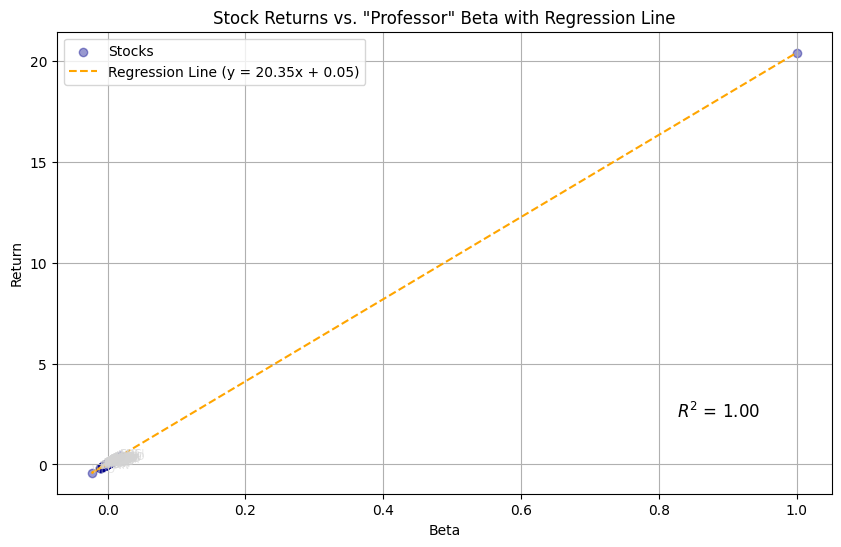

In [177]:
from scipy.stats import linregress

# Extract Beta and Return values for regression
x = beta_mp_df['Beta']
y = beta_mp_df['mean_returns']

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calculate the regression line
regression_line = slope * x + intercept


# Plot the scatter plot and regression line
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='darkblue', alpha=0.4, label='Stocks')
plt.plot(x, regression_line, color='orange', linestyle='--', label=f'Regression Line (y = {slope:.2f}x + {intercept:.2f})')


# Add labels for each stock
for ticker in beta_df.index:
    plt.text(beta_df.loc[ticker, 'Beta'], beta_df.loc[ticker, 'mean_returns'], ticker, color='lightgrey', fontsize=7, alpha=0.6, ha='left')

# Display R-squared value on the plot
plt.text(0.8, 0.2, f'$R^2$ = {r_value**2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

# Set plot labels and title
plt.xlabel('Beta')
plt.ylabel('Return')
plt.title('Stock Returns vs. "Professor" Beta with Regression Line')
plt.grid(True)
plt.legend()
plt.show()

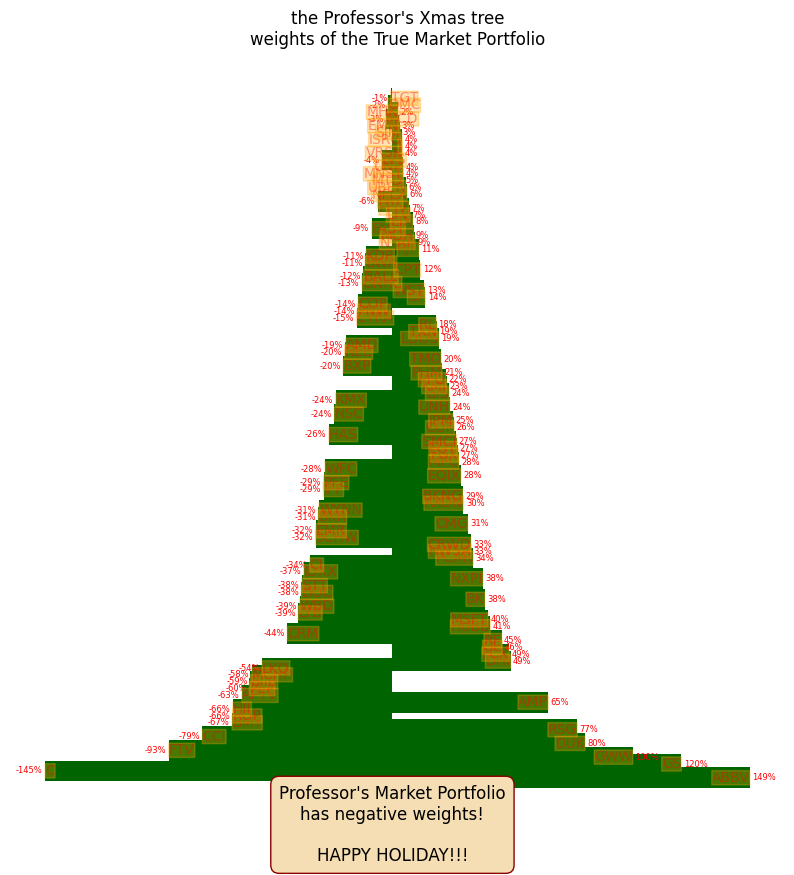

In [148]:
from matplotlib.patches import FancyBboxPatch

xmas_tree = y_weights.reindex(y_weights.abs().sort_values().index).iloc[::-1]

fig, ax = plt.subplots(figsize=(10, 10))
bars = plt.barh(range(len(xmas_tree)), xmas_tree, color='darkgreen', height=3.0)

# Remove y-axis labels
plt.yticks([])
plt.xticks([])

# Display values as percentages in red next to each bar
for bar in bars:
    width = bar.get_width()
    label_x_pos = width + 0.01 if width > 0 else width - 0.01
    ha = 'left' if width > 0 else 'right'
    plt.text(label_x_pos, bar.get_y() + bar.get_height()/2,
             f'{width:.0%}', size= 6, ha=ha, va='center', color='red')

# Add index labels with rounded edges
# Add index labels with rounded edges
for i, (index, value) in enumerate(xmas_tree.items()):
    # Define the position for the label
    y = i
    x = value if value > 0 else value  # Adjust position based on bar direction
    ha = 'right' if value > 0 else 'left'

    # Create a rounded box
    #bbox_props = dict(boxstyle="round,pad=0.01", edgecolor="orange", facecolor="orange", alpha=0.3, zorder=2)
    ax.text(x, y, index, ha=ha, va='center', bbox=bbox_props, color='red', alpha=0.4)


plt.text(0, -1, 'Professor\'s Market Portfolio\nhas negative weights!\n \nHAPPY HOLIDAY!!!', ha='center', va='top',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=1, edgecolor='darkred'),
         fontsize=12)

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)

plt.title('the Professor\'s Xmas tree\nweights of the True Market Portfolio')

plt.show()


{'boxstyle': 'round,pad=0.3', 'edgecolor': 'black', 'facecolor': 'lightgray'}

In [178]:
beta_df.sort_values(by='Beta', ascending=False)

,mean_returns,variance,volatility,Beta
SMCI,0.415690,0.306311,0.553454,0.017970
EQT,0.402285,0.441212,0.664238,0.017311
FCX,0.362098,0.352490,0.593708,0.015336
MOH,0.302611,0.155488,0.394320,0.012413
AXON,0.258172,0.300079,0.547795,0.010229
...,...,...,...,...
HAS,-0.150126,0.158540,0.398171,-0.009834
C,-0.159035,0.212076,0.460518,-0.010272
WYNN,-0.182321,0.419059,0.647348,-0.011416
BXP,-0.190513,0.167352,0.409086,-0.011819


In [179]:
def recalculate_stock_return(ticker):
  return (mp['mean_returns'] - risk_free_rate) * beta_df.loc[ticker]['Beta'] + risk_free_rate

In [181]:
pick = 'BXP'
recalculate_stock_return(pick)

-0.19051288891154017